<a href="https://colab.research.google.com/github/ajsanjoaquin/mPerturb/blob/master/Demo_Usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Generate Perturbed Images for any Black-Box Neural Network

In [ ]:
!pip install timm
!git clone https://github.com/ajsanjoaquin/mPerturb.git
%cd mPerturb

     |████████████████████████████████| 245kB 7.7MB/s 
Cloning into 'mPerturb'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 19 (delta 5), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (19/19), done.
/content/mPerturb


Predicted class index: 698. Probability before perturbation: 0.739530086517334
Loss: 0.004238013178110123, Probability for target class 0.004238013178110123
Loss: 0.0017531514167785645, Probability for target class 0.0009172628633677959
Loss: 0.0012796357041224837, Probability for target class 0.000255462626228109
Loss: 0.0010746479965746403, Probability for target class 0.00015837584214750677
Loss: 0.0017076933290809393, Probability for target class 0.0008195137488655746


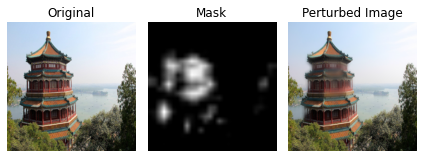

In [ ]:
import timm
import torch
from torchvision import models
import torchvision.transforms as transforms
from perturb import perturb

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device).eval()

transforms = transforms.Compose([transforms.ToTensor(),\
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# Define Image
img_path = '/content/china.jpg'

perturb(img_path, model, transforms=transforms)

Predicted class index: 698. Probability before perturbation: 0.5110312700271606
Loss: 0.02285182662308216, Probability for target class 0.02285182662308216
Loss: 0.003175182733684778, Probability for target class 9.18274381547235e-05
Loss: 0.002234270330518484, Probability for target class 0.0003762687265407294
Loss: 0.0015941509045660496, Probability for target class 0.00032621179707348347
Loss: 0.0016796672716736794, Probability for target class 0.0006779571413062513


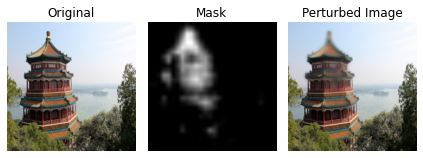

In [ ]:
# Resnet 50
model = models.resnet50(pretrained=True).to(device).eval()
perturb('/content/china.jpg', model, transforms=transforms)

# II. Suppressing Adversarial Noises
Conceptually similar labels (Palace and Castle).I will only show the Indices here, but they correspond to the [Imagenet labels](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

Initialize Model and Image

In [ ]:
!pip install cma==3.0.3
%cd /content
!git clone https://github.com/Trusted-AI/adversarial-robustness-toolbox.git
%cd adversarial-robustness-toolbox

import torch
from torchvision import models
import torchvision.transforms as transforms
import timm

from PIL import Image
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt

from art.estimators.classification import PyTorchClassifier

adv = adv[0].transpose(1, 2, 0)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def img2tensor(image_path, numpy=False):
  '''
  Parameters:
  image_path: Path to image
  numpy: Return a numpy array
  Returns: Tensor (default) or Numpy array
  '''
  orig_image = np.array(Image.open(img_path).convert('RGB').resize((224, 224)))
  return orig_image if numpy else transforms(orig_image).unsqueeze(0).to(device)

def plot_images(orig, orig_label, adv, adv_label):
  plt.figure()

  plt.subplot(121)
  plt.title("Label on original: {}".format(orig_label))
  plt.imshow(orig)
  plt.axis('off')

  plt.subplot(122)
  plt.title('Label on adversarial {}'.format(adv_label))
  plt.imshow(adv)
  plt.axis('off')

  plt.tight_layout()
  plt.show()

# Create output folder
adv_output = '/content/adv_outputs'
if not os.path.exists(adv_output):
  os.mkdir(adv_output)

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

transforms = transforms.Compose([transforms.ToTensor(),\
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Initialize Model
criterion = torch.nn.CrossEntropyLoss()  # Unused but the module requires it
model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device).eval()
m = PyTorchClassifier(
    model=model,
    input_shape=(3, 224, 224),
    loss=criterion,
    nb_classes=1000
)

# Define Image
img_path = '/content/china.jpg'
img_np = img2tensor(img_path, numpy=True)
img_tensor = img2tensor(img_path)

# Original predicted label (Palace)
label = np.argmax(torch.nn.Softmax(dim=1)(model(img_tensor)).cpu().data.numpy())

#Target Label
target_label = 483  # castle
label_vec = np.zeros((1,1000))
label_vec[0][target_label] = 1

     |████████████████████████████████| 235kB 15.1MB/s 
/content
Cloning into 'adversarial-robustness-toolbox'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 50306 (delta 68), reused 28 (delta 20), pack-reused 50187
Receiving objects: 100% (50306/50306), 177.18 MiB | 35.89 MiB/s, done.
Resolving deltas: 100% (39741/39741), done.
/content/adversarial-robustness-toolbox


## A. Fast Gradient Sign-Method (FGSM)
(white-box, targeted attack)

*In my experiments, the perturbed image is classified with its original label when it is saved as a picture and read again by the model. The adversarial noise is probably suppressed by the transformations performed on the numpy array in the process of being saved as an image. 

Therefore, I used the original adversarial image tensor, which correctly fools the model, as input to generate the mask.

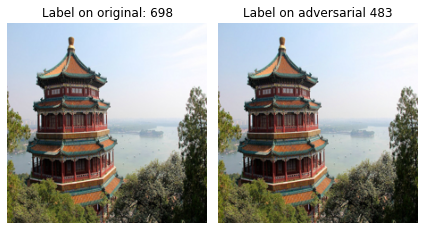

In [ ]:
from art.attacks.evasion import FastGradientMethod

attack = FastGradientMethod(estimator=m, norm='inf', eps=0.01, targeted=True)
adv = attack.generate(x=img_tensor.to('cpu'), y=label_vec)
adv_label = np.argmax(torch.nn.Softmax(dim=1)(model(torch.from_numpy(adv).to(device))).cpu().data.numpy())

# Undo transformations to save the image
adv = (adv * std) + mean
adv = (adv * 255).astype(np.uint8)
Image.fromarray(adv).save(join(adv_output, "adv_FGSM.png"))
plot_images(img_np, label, adv, adv_label)

Predicted class index: 483. Probability before perturbation: 0.49066856503486633
Loss: 0.0011134837986901402, Probability for target class 0.0011134837986901402
Loss: 0.0011292672716081142, Probability for target class 0.0007670177146792412
Loss: 0.0010085757821798325, Probability for target class 0.0006524880300275981
Loss: 0.0009765533031895757, Probability for target class 0.0006340400432236493
Loss: 0.0013525516260415316, Probability for target class 0.0010412882547825575


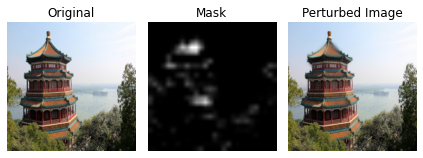

In [ ]:
%cd /content/mPerturb
from perturb import perturb

perturb(adv, model, transforms=transforms, out_dir='/content/adv_perturb_out', is_numpy=True)

Predicted class index: 698. Probability before perturbation: 0.739530086517334
Loss: 0.004238013178110123, Probability for target class 0.004238013178110123
Loss: 0.0017531514167785645, Probability for target class 0.0009172628633677959
Loss: 0.0012796357041224837, Probability for target class 0.000255462626228109
Loss: 0.0010746479965746403, Probability for target class 0.00015837584214750677
Loss: 0.0017076933290809393, Probability for target class 0.0008195137488655746


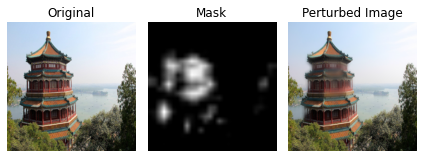

In [ ]:
perturb(img_path, model, transforms=transforms)

In [ ]:
clean_img_path = '/content/adv_perturb_out/perturbed.png'
cleaned_image = img2tensor(clean_img_path)
cleaned_image_label = np.argmax(torch.nn.Softmax(dim=1)(model(cleaned_image)).cpu().data.numpy())

print("Original Predicted Label: {}, Cleaned Image Predicted Label: {}"\
        .format(label, cleaned_image_label))

Original Predicted Label: 698, Cleaned Image Predicted Label: 698


## B. Pixel Attack

/content/adversarial-robustness-toolbox


differential_evolution step 1: f(x)= -0.429036
differential_evolution step 1: f(x)= 0.748344
differential_evolution step 1: f(x)= 0.337247
differential_evolution step 1: f(x)= 1.66807
differential_evolution step 1: f(x)= 3.02382
differential_evolution step 1: f(x)= 3.07144
differential_evolution step 1: f(x)= 3.70743



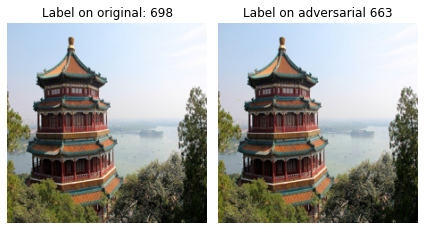

In [ ]:
%cd /content/adversarial-robustness-toolbox
from art.attacks.evasion import PixelAttack

attack = PixelAttack(m, es=1, verbose=True)
adv = attack.generate(x=img_tensor.to('cpu'))

adv_label = np.argmax(torch.nn.Softmax(dim=1)(model(torch.from_numpy(adv).to(device))).cpu().data.numpy())

# Undo transformations to save the image
adv = adv[0].transpose(1, 2, 0)
adv = (adv * std) + mean
adv = (adv * 255).astype(np.uint8)
Image.fromarray(adv).save(join(adv_output, "adv_PA.png"))

plot_images(img_np, label, adv, adv_label)  # It thinks it's a traffic light

Predicted class index: 698. Probability before perturbation: 0.7390097975730896
Loss: 0.00260277115739882, Probability for target class 0.00260277115739882
Loss: 0.0022713537327945232, Probability for target class 0.0015967143699526787
Loss: 0.0009167550597339869, Probability for target class 0.00045332201989367604
Loss: 0.0007648970931768417, Probability for target class 0.0002834758488461375
Loss: 0.0010284647578373551, Probability for target class 0.000539319880772382


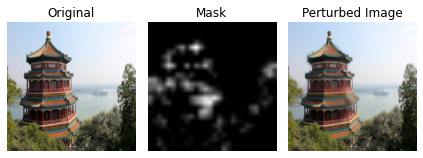

In [ ]:
%cd /content/mPerturb
from perturb import perturb

perturb(adv, model, transforms=transforms, out_dir='/content/adv_perturb_out', is_numpy=True)

In [ ]:
clean_img_path = '/content/adv_perturb_out/perturbed.png'
cleaned_image = img2tensor(clean_img_path)
cleaned_image_label = np.argmax(torch.nn.Softmax(dim=1)(model(cleaned_image)).cpu().data.numpy())

print("Original Predicted Label: {}, Cleaned Image Predicted Label: {}"\
        .format(label, cleaned_image_label))

Original Predicted Label: 698, Cleaned Image Predicted Label: 698
